In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_linnerud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [13]:
import datetime

In [2]:
from tensorflow.keras.callbacks import TensorBoard

In [3]:
df = pd.read_csv('D:\ParisHousing.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Honor\AppData\Local\Temp\ipykernel_3236\3147050155.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('D:\ParisHousing.csv')


In [4]:
df.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

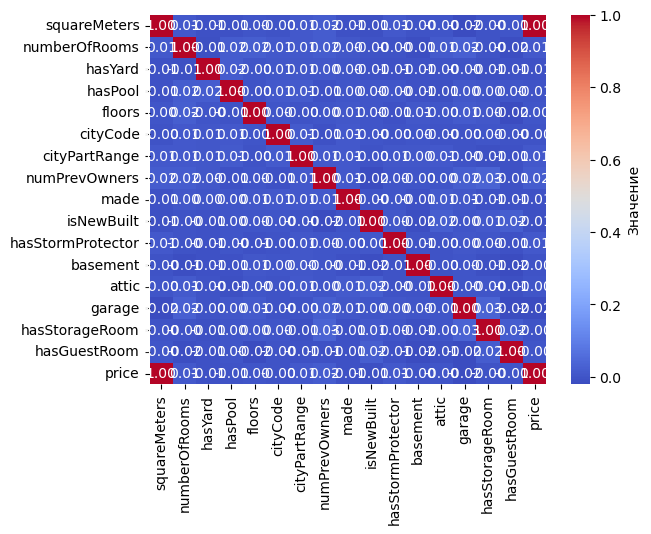

In [9]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Значение'})
plt.show()

In [4]:
X = df.drop(columns = ['price']).values
y = df['price'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=3)

In [6]:
X_train.shape

(8000, 16)

In [7]:
# Создаем модель
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(16,)),
    keras.layers.Dense(32, activation='relu'),

    keras.layers.Dense(1)
])

C:\Anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
tb_callbacks = TensorBoard(log_dir='my_dir/logs', histogram_freq=1)

In [9]:
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

In [10]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.MeanSquaredError('MSE')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.MeanSquaredError('MSE')

In [16]:
def train_step(model, optimizer, X_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(X_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

def test_step(model, X_test, y_test):
    predictions = model(X_test)
    loss = loss_object(y_test, predictions)

    test_loss(loss)
    test_accuracy(y_test, predictions)

In [14]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'my_dir/logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'my_dir/logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [20]:
EPOCHS = 100

for epoch in range(EPOCHS):
    train_step(model, optimizer, X_train, y_train)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('MSE', train_accuracy.result(), step=epoch)

    test_step(model, X_test, y_test)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('MSE', test_accuracy.result(), step=epoch)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result(),
                         test_loss.result(), 
                         test_accuracy.result()))

    # Reset metrics every epoch
    train_loss.reset_state()
    test_loss.reset_state()
    train_accuracy.reset_state()
    test_accuracy.reset_state()

Epoch 1, Loss: 21685382152192.0, Accuracy: 21685382152192.0, Test Loss: 21563179008000.0, Test Accuracy: 21563179008000.0
Epoch 2, Loss: 21444939481088.0, Accuracy: 21444939481088.0, Test Loss: 21322228826112.0, Test Accuracy: 21322228826112.0
Epoch 3, Loss: 21201946673152.0, Accuracy: 21201946673152.0, Test Loss: 21078814490624.0, Test Accuracy: 21078814490624.0
Epoch 4, Loss: 20956489711616.0, Accuracy: 20956489711616.0, Test Loss: 20833024081920.0, Test Accuracy: 20833024081920.0
Epoch 5, Loss: 20708660871168.0, Accuracy: 20708660871168.0, Test Loss: 20584920514560.0, Test Accuracy: 20584920514560.0
Epoch 6, Loss: 20458525163520.0, Accuracy: 20458525163520.0, Test Loss: 20334604451840.0, Test Accuracy: 20334604451840.0
Epoch 7, Loss: 20206164377600.0, Accuracy: 20206164377600.0, Test Loss: 20082151391232.0, Test Accuracy: 20082151391232.0
Epoch 8, Loss: 19951664496640.0, Accuracy: 19951664496640.0, Test Loss: 19827664093184.0, Test Accuracy: 19827664093184.0
Epoch 9, Loss: 196951282

Epoch 69, Loss: 5727683870720.0, Accuracy: 5727683870720.0, Test Loss: 5786159284224.0, Test Accuracy: 5786159284224.0
Epoch 70, Loss: 5602891268096.0, Accuracy: 5602891268096.0, Test Loss: 5665008386048.0, Test Accuracy: 5665008386048.0
Epoch 71, Loss: 5482875977728.0, Accuracy: 5482875977728.0, Test Loss: 5548530991104.0, Test Accuracy: 5548530991104.0
Epoch 72, Loss: 5367575085056.0, Accuracy: 5367575085056.0, Test Loss: 5436656320512.0, Test Accuracy: 5436656320512.0
Epoch 73, Loss: 5256923054080.0, Accuracy: 5256923054080.0, Test Loss: 5329310973952.0, Test Accuracy: 5329310973952.0
Epoch 74, Loss: 5150843863040.0, Accuracy: 5150843863040.0, Test Loss: 5226403725312.0, Test Accuracy: 5226403725312.0
Epoch 75, Loss: 5049254150144.0, Accuracy: 5049254150144.0, Test Loss: 5127866941440.0, Test Accuracy: 5127866941440.0
Epoch 76, Loss: 4952072650752.0, Accuracy: 4952072650752.0, Test Loss: 5033608871936.0, Test Accuracy: 5033608871936.0
Epoch 77, Loss: 4859204468736.0, Accuracy: 48592

In [36]:
model.fit(X_train, y_train, epochs=30, batch_size = 32, callbacks=[tb_callbacks])

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 29974396403712.0000 - mean_absolute_error: 4705429.5000
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3742585585664.0000 - mean_absolute_error: 1569709.5000
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 579998646272.0000 - mean_absolute_error: 594398.5000
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 24394784768.0000 - mean_absolute_error: 117080.8906
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6616254464.0000 - mean_absolute_error: 58701.1797
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2371293440.0000 - mean_absolute_error: 29801.3965
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1122799872.0000 - mean_absolute_error: 20264.1875
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 775126720.0000 - mean_absolute_error: 16465.6699
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 472491328.0000 - mean_absolute_error: 13175.0

In [37]:
# Оценим точность модели
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=2)
print('\nТестовая ошибка:', test_loss)
print('\nТестовая точность:', )

63/63 - 1s - 10ms/step - loss: 9848543.0000 - mean_absolute_error: 2492.9026

Тестовая ошибка: 9848543.0

Тестовая точность: 2492.902587890625
